## RFM Customer segmentation

The goal of RFM Analysis is to segment customers based on buying behavior. We
need to understand the historical actions of individual customers for each RFM factor. We then
rank customers based on each individual RFM factor, and finally pull all the factors together to
create RFM segments for targeted marketing. 

- Can you identify your best customers?
- Do you know who your worst customers are?
- Do you know which customers you just lost, and which ones you’re about to lose?
- Can you identify loyal customers who buy often, but spend very little?
- Can you target customers who are willing to spend the most at your store?



# RFM Analysis: The Key to Understanding Customer Buying Behavior

**SET THE WORKING DIRECTORY SO THAT WE DO NOT HAVE TO THINK ABOUT PATH PROBLEMS**



##  Import required modules

In [1]:
!pip install squarify

In [0]:
#Import packages

import numpy as np
import pandas as pd
import warnings


from sklearn.cluster import KMeans

import squarify
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings('ignore')

##  Read data

In [3]:
!wget https://raw.githubusercontent.com/Avinash007/datasets/master/Online%20Retail.xlsx

--2019-09-14 17:13:31--  https://raw.githubusercontent.com/Avinash007/datasets/master/Online%20Retail.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19768043 (19M) [application/octet-stream]
Saving to: ‘Online Retail.xlsx’

Online Retail.xlsx  100%[===================>]  18.85M  --.-KB/s    in 0.1s    

2019-09-14 17:13:32 (145 MB/s) - ‘Online Retail.xlsx’ saved [19768043/19768043]



In [0]:
df_retail = pd.read_excel("Online Retail.xlsx")


## Inspect and explore 

In [5]:
df_retail.head()                                 # check the head of the data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
df_retail.info()                                # check datatypes and and compute total number of transactions 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [7]:
df_retail[['Quantity','UnitPrice']].describe()   # summary statistics

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


**Observation:** There are many negative values in both Quantity and Unit price which makes mean and minimum value quite bizarre. As a result some amount of data cleaning is required.

## Data cleaning

### Display all countries from which data was collected

In [0]:
#Create a copy of dataframe
df_retail_copy = df_retail

In [9]:
#All unique countries from which data was retrieved
df_retail_copy.Country.nunique()

38

In [10]:
df_retail_copy.Country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [11]:
# Drop duplicate rows
customer_country=df_retail_copy[['Country','CustomerID']].drop_duplicates()

# Country wise customer counts
customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False).head()

,Country,CustomerID
36,United Kingdom,3950
14,Germany,95
13,France,87
31,Spain,31
3,Belgium,25


More than 90% of the customers in the data are from United Kingdom, There is research indicating that customer clusters vary by geography, so we restrict the data to United Kingdom only.

In [0]:
# Drop duplicate rows
customer_country=df_retail_copy[['Country','CustomerID']].drop_duplicates()

In [0]:
# Focus the dataset on United Kingdom 
df_retail_uk = df_retail_copy.loc[df_retail_copy['Country'] == 'United Kingdom']

In [14]:
df_retail_uk.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [15]:
df_retail_uk = df_retail_uk[pd.notnull(df_retail_uk['CustomerID'])]
df_retail_uk.isnull().sum(axis=0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [16]:
## Percentage Negative values in Quantity column 

len(df_retail_uk[df_retail_uk.Quantity<0])*100/len(df_retail_uk)

2.0816407739624956

There are around 2% of negative quantity values that are going to be removed.

In [17]:
#Choose only rows of data wherein Quantity is positive

df_retail_uk = df_retail_uk[(df_retail_uk['Quantity']>0)]

df_retail_uk.Quantity.min()

1

In [18]:
df_retail_uk.shape

(354345, 8)

In [0]:
#Calculate total price

df_retail_uk['TotalPrice'] = df_retail_uk['Quantity'] * df_retail_uk['UnitPrice']

### Find last invoice date for all transactions 

In [20]:
#Find minimum invoice date
df_retail_uk['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [21]:
#Find maximum invoice date
df_retail_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [22]:
#Add 1 day to the maximum onvoice date in order to effectively count number of days and to avoid 0 value
import datetime as dt
NOW = df_retail_uk['InvoiceDate'].max() + dt.timedelta(1)
NOW

Timestamp('2011-12-10 12:49:00')

## Data visualization

### Sales on weekdays

Text(0.5, 0, 'Hours')

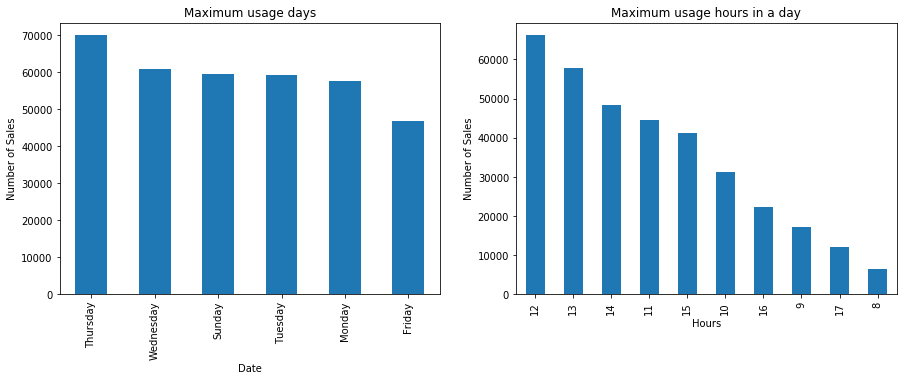

In [23]:
# Plot amount of sales on days of the week

fig,ax=plt.subplots(1,2)
df_retail_uk.InvoiceDate.dt.weekday_name.value_counts().nlargest(10).plot(kind='bar', figsize=(15,5),ax=fig.axes[0])
ax[0].set_title("Maximum usage days")
ax[0].set_ylabel('Number of Sales')
ax[0].set_xlabel('Date')

df_retail_uk.InvoiceDate.dt.hour.value_counts().nlargest(10).plot(kind='bar', figsize=(15,5),ax=fig.axes[1])
plt.title("Maximum usage hours in a day")
plt.ylabel('Number of Sales')
plt.xlabel('Hours')

**Observation**:

Maximum sales happen on Thursdays and Wednesdays around 11 AM to 3 PM and so we have to start triggering offers and special incentives on these days

### Proportion of one time and repeat customers

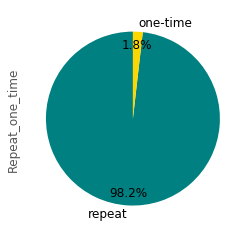

In [24]:
df_retail_uk_custid=df_retail_uk.CustomerID.value_counts().to_frame()
df_retail_uk_custid['Repeat_one_time'] = np.where((df_retail_uk_custid.CustomerID>1), 'repeat', 'one-time')

plt.style.use('ggplot')

media_df=df_retail_uk_custid
media_per_user_group=media_df.groupby(['Repeat_one_time'])['Repeat_one_time'].count().nlargest(2)
media_per_user_group.plot(kind='pie', colors = ['teal','gold'], fontsize=12, autopct='%1.1f%%', startangle=90, pctdistance=0.85)
plt.show()

**Observation**:

The percentage of repeat customers are substantially more than the percentage of one-time customers. Mostly customers are happy with the retail store, We have to convert the one-time customers into repeat customers by offering them good incentives and proper service. 

#### Which are the most popular products in UK?

In [25]:
uk_product = df_retail_uk.groupby(['StockCode','Description'],as_index= False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)
uk_product.head(10)

,StockCode,Description,Quantity
2514,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
2016,23166,MEDIUM CERAMIC TOP STORAGE JAR,76919
2690,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,49182
3548,85099B,JUMBO BAG RED RETROSPOT,41981
3555,85123A,WHITE HANGING HEART T-LIGHT HOLDER,34648
2795,84879,ASSORTED COLOUR BIRD ORNAMENT,32727
1031,22197,POPCORN HOLDER,28935
1426,22616,PACK OF 12 LONDON TISSUES,24337
37,17003,BROCADE RING PURSE,22711
356,21212,PACK OF 72 RETROSPOT CAKE CASES,22465


#### Which are the least popular products in UK?

In [26]:
uk_product.tail(10)

,StockCode,Description,Quantity
2593,47579,TEA TIME BREAKFAST BASKET,1
3354,84569C,PACK 4 FLOWER/BUTTERFLY PATCHES,1
3055,35004P,SET OF 3 PINK FLYING DUCKS,1
2650,77079,DOLPHIN WINDMILL,1
2562,37461,FUNKY MONKEY MUG,1
796,21895,POTTING SHED SOW 'N' GROW SET,1
3162,47503J,SET/3 FLORAL GARDEN TOOLS IN BAG,1
2921,90071,RUBY GLASS CLUSTER EARRINGS,1
3706,90065B,BLACK VINT ART DEC CRYSTAL BRACELET,1
760,21839,MUMMY MOUSE RED GINGHAM RIBBON,1


## RFM Analysis

**RFM (Recency, Frequency, Monetary)** analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. 
RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

- RECENCY (R): Days since last purchase
- FREQUENCY (F): Total number of purchases
- MONETARY VALUE (M): Total money this customer spent.
We will create those 3 customer attributes for each customer.

In [0]:
#Convert Invoice date to datetime
df_retail_uk['InvoiceDate'] = pd.to_datetime(df_retail_uk['InvoiceDate'])

### Calculate recency, frequency and monetary value using past user behaviour

In [0]:
#Calculate recency, frequency and monetary value of past user behaviour

rfmTable = df_retail_uk.groupby('CustomerID').agg({'InvoiceDate': lambda x: (NOW - x.max() ).days, # Recency
                                        'InvoiceNo': lambda x: len(x),      # Frequency
                                        'TotalPrice': lambda x: x.sum()}) # Monetary Value

rfmTable['InvoiceDate'] = rfmTable['InvoiceDate'].astype(int)
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                         'InvoiceNo': 'frequency', 
                         'TotalPrice': 'monetary_value'}, inplace=True)

In [29]:
#Display RFM table
rfmTable.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,326,1,77183.60
12747.0,2,103,4196.01
12748.0,1,4596,33719.73
12749.0,4,199,4090.88
12820.0,3,59,942.34


Interpretation:

* CustomerID 12346 has frequency: 1, monetary value: $77183.60 and recency: 326 days.

* CustomerID 12747 has frequency: 103, monetary value: $4196.01 and recency: 2 days.

Let's check the details of the first customer.

In [30]:
first_customer = df_retail_uk[df_retail_uk['CustomerID']== 12346.0]
first_customer

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6


**Observation**:

The first customer has shopped only once, bought one item at a huge quantity(74215). The unit price is very low, seems a clearance sale.

### Segmented RFM table using quartiles

The easiest way to split metrics into segments is by using quartile.

- This gives us a starting point for detailed analysis
- 4 segments are easy to understand and explain

In [31]:
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value
0.25,18.0,17.0,300.04
0.50,51.0,41.0,651.82
0.75,143.0,99.0,1575.89


In [32]:
#Convert quantiles to dictionary
quantiles = quantiles.to_dict()
quantiles

{'frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 99.0},
 'monetary_value': {0.25: 300.03999999999996,
  0.5: 651.8199999999999,
  0.75: 1575.89},
 'recency': {0.25: 18.0, 0.5: 51.0, 0.75: 143.0}}

In [0]:
segmented_rfm = rfmTable

### Lowest recency, highest frequency and monetary are our best customers

* For recency a good customer would be a part of the lowest quartile designated as '1'
* For frequency and monetary a good customer would be a part of the highest quartile here designated as '1'


In [0]:
# Create functions to separate customers into segments such as 1,2,3,4 based on quantile allocation.

def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [0]:
# Assign segments to customers

segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))

In [36]:
#Explore the resultant segmented RFM table

segmented_rfm.head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,326,1,77183.60,4,4,1
12747.0,2,103,4196.01,1,1,1
12748.0,1,4596,33719.73,1,1,1
12749.0,4,199,4090.88,1,1,1
12820.0,3,59,942.34,1,2,2


In [37]:
#Create a new column with combined RFM Score

segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) \
                            + segmented_rfm.f_quartile.map(str) \
                            + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()


,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
12346.0,326,1,77183.60,4,4,1,441
12747.0,2,103,4196.01,1,1,1,111
12748.0,1,4596,33719.73,1,1,1,111
12749.0,4,199,4090.88,1,1,1,111
12820.0,3,59,942.34,1,2,2,122


### Data visualization

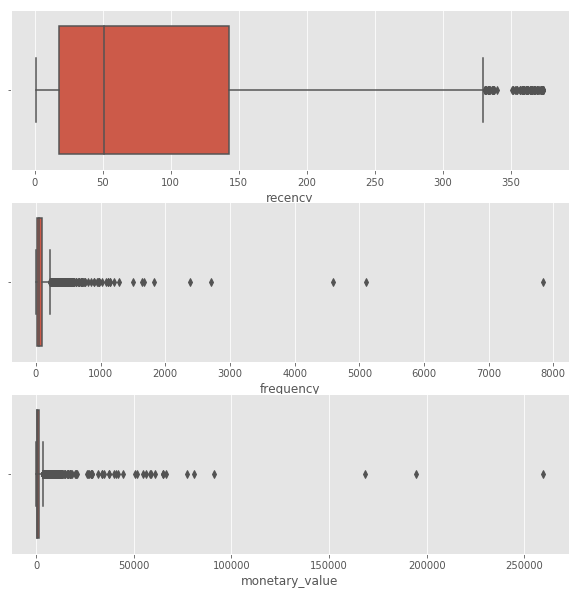

In [38]:
# Plot recency, freqiency and moneatry distribution
fig,ax=plt.subplots(3,1)
fig.set_size_inches(w=10,h=10)
sns.boxplot(x='recency',data=rfmTable,ax=fig.axes[0])
sns.boxplot(x='frequency',data=rfmTable,ax=fig.axes[1])
sns.boxplot(x='monetary_value',data=rfmTable,ax=fig.axes[2])


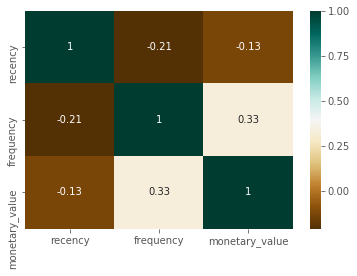

In [39]:
c= rfmTable[['recency','frequency','monetary_value']].corr()
sns.heatmap(data=c,cmap="BrBG",annot=True)
plt.show()

**Observation** :

- Frequency and monetary value are positively correlated with each other implying an increase in frequency implies increase in monetary value
- Frequency and Recency are negatively correlated with each other implying an increase in frequency implies decrease in monetary value

## Target different customer segments

### 1. Best customers

* These are the customers that bought recently, buy often and spend a lot. It’s likely that they will continue to do so. 
* Since they already like you so much, consider marketing to them without price incentives to preserve your profit margin. 
* Be sure to tell these customers about new products you carry, how to connect on social networks, and any loyalty programs or social media incentives you run.

In [40]:
segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore
CustomerID,,,,,,,
18102.0,1,431,259657.30,1,1,1,111
17450.0,8,337,194550.79,1,1,1,111
17511.0,3,963,91062.38,1,1,1,111
16684.0,4,277,66653.56,1,1,1,111
14096.0,4,5111,65164.79,1,1,1,111


In [0]:
segmented_rfm['Segment_Type'] = np.where(segmented_rfm['RFMScore']=='111','Best customers','NA')

### 2. Big Spenders
* Big spenders have spent a lot of money over their lifetime as your customer. 
* They trust you enough to invest a lot in your products. 
* Considering marketing your most expensive products and top of the line models to this group

In [42]:
# Another way to extract: segmented_rfm[segmented_rfm['RFMScore'].apply(lambda x: str(x)[-1])=='1'].sort_values('monetary_value', ascending=False)
segmented_rfm[segmented_rfm['m_quartile']==1].sort_values('monetary_value', ascending=False).head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,Segment_Type
CustomerID,,,,,,,,
18102.0,1,431,259657.30,1,1,1,111,Best customers
17450.0,8,337,194550.79,1,1,1,111,Best customers
16446.0,1,3,168472.50,1,4,1,141,NA
17511.0,3,963,91062.38,1,1,1,111,Best customers
16029.0,39,242,81024.84,2,1,1,211,NA


In [0]:
a=segmented_rfm[(segmented_rfm['Segment_Type']=='NA') & (segmented_rfm['RFMScore'].apply(lambda x: str(x)[-1])=='1')]['Segment_Type'].replace('NA','Big Spenders')
ind=a.index
segmented_rfm['Segment_Type'][ind]='Big Spenders'

### 3. Loyal customers
Anyone with a high frequency should be considered loyal. This
doesn’t mean they have necessarily bought recently, or that
they spent a lot, though you could define that with your R and
M factors.

In [44]:
#segmented_rfm[segmented_rfm['RFMScore'].apply(lambda x: str(x)[-2])=='1'].sort_values('frequency', ascending=False)
segmented_rfm[segmented_rfm['f_quartile']==1].sort_values('frequency', ascending=False).tail()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,Segment_Type
CustomerID,,,,,,,,
17451.0,1,100,1721.40,1,1,1,111,Best customers
16031.0,92,100,548.94,3,1,3,313,NA
15113.0,10,100,3609.33,1,1,1,111,Best customers
15106.0,18,100,1422.52,1,1,2,112,NA
14292.0,8,100,4871.93,1,1,1,111,Best customers


In [0]:
a=segmented_rfm[(segmented_rfm['Segment_Type']=='NA') & (segmented_rfm['RFMScore'].apply(lambda x: str(x)[-2])=='1')]['Segment_Type'].replace('NA','Loyal Customers')
ind=a.index
segmented_rfm['Segment_Type'][ind]='Loyal Customers'

### 4. Loyal Joes

* Loyal Joes buy often, but don’t spend very much. 
* Goal should be to increase the share of wallet you have from this customer.
* Send offers that require them to “Spend *100 rupees* to save 20 rupees” and “Buy 4, Get 1 Free.” These offers create high hurdles that must be cleared to gain the reward, and will increase the amount these loyal customers spend with you.

In [46]:
segmented_rfm[segmented_rfm['RFMScore'].apply(lambda x: str(x)[-2:])=='14']

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,Segment_Type
CustomerID,,,,,,,,
17254.0,5,112,272.44,1,1,4,114,Loyal Customers


In [0]:
a=segmented_rfm[(segmented_rfm['Segment_Type']=='Loyal Customers') & (segmented_rfm['RFMScore'].apply(lambda x: str(x)[-2:])=='14')]['Segment_Type'].replace('Loyal Customers','Loyal Joes')
ind=a.index
segmented_rfm['Segment_Type'][ind]='Loyal Joes'

### 5. New spenders
* New Spenders are new customers that spent a lot of money on their first order(s). This is the kind of customer you want to convert into a loyal, regular customer that loves your products and brand. Be sure to welcome them and thank them for making a first purchase, and follow it up with unique incentives to come back again. 
* Consider branding the email with a special note from the CEO, and include a survey to ask about their experience

In [48]:
segmented_rfm[segmented_rfm['RFMScore']=='141'].sort_values('monetary_value', ascending=False).head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,Segment_Type
CustomerID,,,,,,,,
16446.0,1,3,168472.5,1,4,1,141,Big Spenders
16000.0,3,9,12393.7,1,4,1,141,Big Spenders
16532.0,18,4,6748.8,1,4,1,141,Big Spenders
15195.0,3,1,3861.0,1,4,1,141,Big Spenders
15473.0,14,11,1771.2,1,4,1,141,Big Spenders


In [0]:
a=segmented_rfm[(segmented_rfm['Segment_Type']=='Big Spenders') & (segmented_rfm['RFMScore']=='141')]['Segment_Type'].replace('Big Spenders','New Spenders')
ind=a.index
segmented_rfm['Segment_Type'][ind]='New Spenders'

### 6. Lost Customers

* Lost Customers used to buy frequently from you, and at one point they spent a lot with you, but they’ve stopped. Now it’s time to win them back. 
* They might be lost to a competitor; they might not have need of your products anymore, or they might have had a bad customer service experience with you.

In [50]:
segmented_rfm[segmented_rfm['RFMScore']=='411'].sort_values('monetary_value', ascending=False).head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,Segment_Type
CustomerID,,,,,,,,
13093.0,276,159,7832.470,4,1,1,411,Big Spenders
17850.0,372,297,5391.210,4,1,1,411,Big Spenders
15808.0,306,208,3734.970,4,1,1,411,Big Spenders
15379.0,169,194,3703.290,4,1,1,411,Big Spenders
13952.0,218,137,3251.071,4,1,1,411,Big Spenders


In [0]:
a=segmented_rfm[(segmented_rfm['Segment_Type']=='Big Spenders') & (segmented_rfm['RFMScore']=='411')]['Segment_Type'].replace('Big Spenders','Lost Customers')
ind=a.index
segmented_rfm['Segment_Type'][ind]='Lost Customers'

### 7. Almost Lost customers

* It has just been less time since they purchased. These customers might warrant more aggressive discounts so that you can win them back before it’s too late.
* It is much less expensive it is to keep customers compared to winning new ones

In [52]:
segmented_rfm[segmented_rfm['RFMScore']=='311'].sort_values('monetary_value', ascending=False).head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,Segment_Type
CustomerID,,,,,,,,
16180.0,100,162,10254.18,3,1,1,311,Big Spenders
14952.0,60,138,8099.49,3,1,1,311,Big Spenders
16745.0,87,357,7194.30,3,1,1,311,Big Spenders
16652.0,59,118,6773.97,3,1,1,311,Big Spenders
17509.0,58,366,6115.14,3,1,1,311,Big Spenders


In [0]:
a=segmented_rfm[(segmented_rfm['Segment_Type']=='Big Spenders') & (segmented_rfm['RFMScore']=='311')]['Segment_Type'].replace('Big Spenders','Almost Lost Customers')
ind=a.index
segmented_rfm['Segment_Type'][ind]='Almost Lost Customers'

### 8. Splurgers
* Splurgers combine a high Monetary Value with a low Frequency, which means they’ve spent a lot of money in just a few orders. Because they have the wealth and willingness to spend a lot with you, target high priced products with good margins at this group. 
* This group might also correspond with seasonal events or even just the typical buying cycle of your product’s wear.

In [54]:
segmented_rfm[segmented_rfm['RFMScore'].apply(lambda x: str(x)[-2:])=='41'].head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,Segment_Type
CustomerID,,,,,,,,
12346.0,326,1,77183.60,4,4,1,441,Big Spenders
12823.0,75,5,1759.50,3,4,1,341,Big Spenders
13135.0,197,1,3096.00,4,4,1,441,Big Spenders
13631.0,100,11,3070.42,3,4,1,341,Big Spenders
13763.0,63,15,1714.96,3,4,1,341,Big Spenders


In [0]:
a=segmented_rfm[(segmented_rfm['Segment_Type']=='Big Spenders') & (segmented_rfm['RFMScore'].apply(lambda x: str(x)[-2:])=='41')]['Segment_Type'].replace('Big Spenders','Splurgers')
ind=a.index
segmented_rfm['Segment_Type'][ind]='Splurgers'

### 10. Deadbeats
These customers spent very little, bought very few times, and
last ordered quite a while ago. They are unlikely to be worth
much time, so put them in your general house list and
consider a re-opt-in campaign.

In [56]:
segmented_rfm[segmented_rfm['RFMScore']=='444'].sort_values('monetary_value', ascending=False).head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,Segment_Type
CustomerID,,,,,,,,
15609.0,184,16,298.48,4,4,4,444,NA
17678.0,264,16,298.11,4,4,4,444,NA
12881.0,276,7,298.00,4,4,4,444,NA
17531.0,190,14,296.70,4,4,4,444,NA
13751.0,288,9,296.25,4,4,4,444,NA


In [0]:
a=segmented_rfm[(segmented_rfm['Segment_Type']=='NA') & (segmented_rfm['RFMScore']=='444')]['Segment_Type'].replace('NA','Deadbeats')
ind=a.index
segmented_rfm['Segment_Type'][ind]='Deadbeats'

### Treemap for different RFM segments

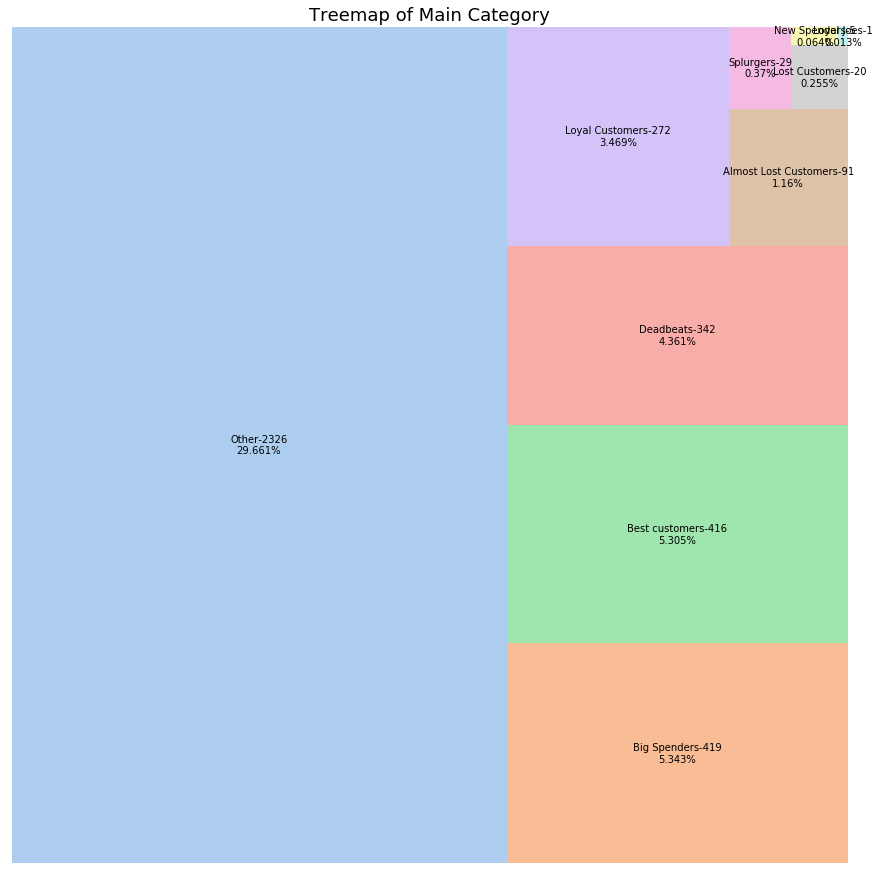

In [58]:
segmented_rfm['Segment_Type']=segmented_rfm['Segment_Type'].str.replace('NA','Other')

fig = plt.figure(figsize = (10,30))
regions = segmented_rfm.Segment_Type.value_counts().to_frame()
regions['count_val']=regions.values
regions['percent']=regions['count_val']/(regions.values.sum())*100
ax = fig.add_subplot(111, aspect = "equal")
ax = squarify.plot(sizes = regions["Segment_Type"].values, label = (regions.index+'-'+regions.count_val.astype(str)+'\n'+regions.percent.round(3).astype(str))+'%',
              color = sns.color_palette("pastel", 20), alpha = 0.8)
ax.set_xticks([])
ax.set_yticks([])
fig = plt.gcf()
fig.set_size_inches(15, 30)
plt.title("Treemap of Main Category", fontsize = 18)
plt.show()

## Building Prediction models for customer segmentation using Kmeans Clustering

### Data preparation

In [59]:
# Let's remove customer with zero monetary value
rfmTable[rfmTable.monetary_value == 0]

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,Segment_Type
CustomerID,,,,,,,,
13256.0,14,1,0.0,1,4,4,144,Other


In [0]:
rfmTable = rfmTable.drop(rfmTable.index[314])

### Let's explore the distribution of recency, frequency and monetary value

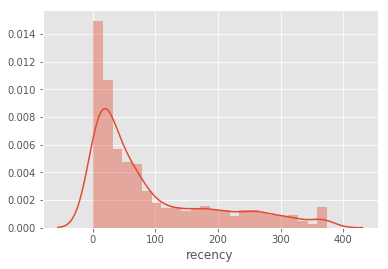

In [61]:
sns.distplot(rfmTable['recency'])
plt.show()

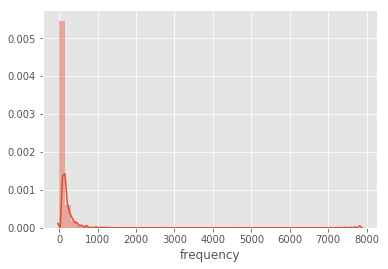

In [62]:
sns.distplot(rfmTable['frequency'])
plt.show()

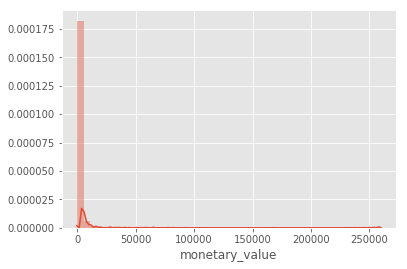

In [63]:
sns.distplot(rfmTable['monetary_value'])
plt.show()

All distributions are highly right skewed. We have make these distributions **normal in order to create meaningful clusters**

In [0]:
#Perform log transformation

rfmTable_log = np.log(rfmTable[['recency','frequency','monetary_value']]+1)

In [65]:
rfmTable_log.head()

,recency,frequency,monetary_value
CustomerID,,,
12346.0,5.789960,0.693147,11.253955
12747.0,1.098612,4.644391,8.342128
12748.0,0.693147,8.433159,10.425868
12749.0,1.609438,5.298317,8.316760
12820.0,1.386294,4.094345,6.849427


In [0]:
# Standardize the recency, frequency, monetary values

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfmTable_log)

# Scale and center the data
rfmTable_log_normalized = scaler.transform(rfmTable_log)

# Create a pandas DataFrame
rfmTable_log_normalized = pd.DataFrame(data=rfmTable_log_normalized, index=rfmTable_log.index, columns=rfmTable_log.columns)

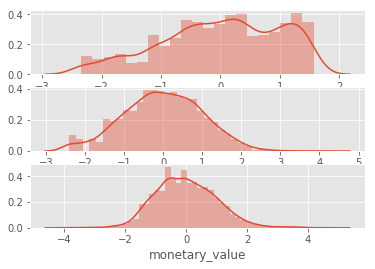

In [67]:
# Plot distributions after log normalization
plt.subplot(3,1,1)
sns.distplot(rfmTable_log_normalized['recency'])
plt.subplot(3,1,2)
sns.distplot(rfmTable_log_normalized['frequency'])
plt.subplot(3,1,3)
sns.distplot(rfmTable_log_normalized['monetary_value'])

Once log transformation and standardization are performed all three distributions become symmetric.

### Model Building

### Step 1: Perform Elbow method to find optimum number of clusters

In [0]:
sse={}
# Fit KMeans and calculate SSE for each k
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(rfmTable_log_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

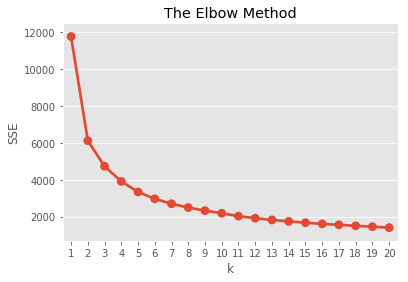

In [69]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))

The optimium number of clusters seems to be 4.

### Step 2: Perform kmeans clustering

In [0]:
# Initialize KMeans
kmeans = KMeans(n_clusters=4,init='k-means++', max_iter=300, n_init=10, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(rfmTable_log_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

### Step 3: Let's explore cluster properties

In [71]:
#Create a DataFrame by adding a new cluster label column
rfm_k4 = rfmTable.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = rfm_k4.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': ['mean', 'count']
  }).round(1)

recency frequency monetary_value      
           mean      mean           mean count
Cluster                                       
0         185.9      15.0          292.6  1255
1          20.5      36.9          568.6   781
2          91.8      82.9         1484.7  1121
3          12.0     280.1         6333.9   763

### Step 4: Which cluster do we have to focus on to improve revenue?

In [0]:
# Melt the normalized dataset and reset the index
rfm_melt = pd.melt(rfm_k4.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables                  
                    id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['recency', 'frequency', 'monetary_value'], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value')

In [73]:
rfm_melt.head()

,CustomerID,Cluster,Metric,Value
0,12346.0,2,recency,326.0
1,12747.0,3,recency,2.0
2,12748.0,3,recency,1.0
3,12749.0,3,recency,4.0
4,12820.0,1,recency,3.0


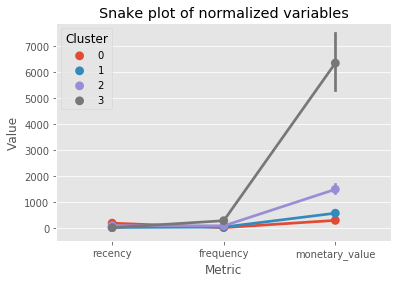

In [74]:
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.pointplot(data=rfm_melt, x='Metric', y='Value', hue='Cluster')

We have to focus on **Cluster 3** to improve revenue

In [75]:
rfm_k4[rfm_k4['Cluster']==3].head()

,recency,frequency,monetary_value,r_quartile,f_quartile,m_quartile,RFMScore,Segment_Type,Cluster
CustomerID,,,,,,,,,
12747.0,2,103,4196.01,1,1,1,111,Best customers,3
12748.0,1,4596,33719.73,1,1,1,111,Best customers,3
12749.0,4,199,4090.88,1,1,1,111,Best customers,3
12826.0,3,91,1474.72,1,2,2,122,Other,3
12839.0,3,314,5591.42,1,1,1,111,Best customers,3


### Step 5: 3d Cluster plot

In [0]:
# Create a new column for cluster names
conditions = [
    (rfm_k4['Cluster'] == 0),
    (rfm_k4['Cluster'] == 1),
    (rfm_k4['Cluster'] == 2),
    (rfm_k4['Cluster'] == 3)]
choices = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']
rfm_k4['Cluster_name'] = np.select(conditions, choices)


In [77]:
!pip install chart_studio

     |████████████████████████████████| 81kB 3.5MB/s 


In [78]:
import plotly
import chart_studio
import chart_studio.plotly as py
import plotly.graph_objs as go
import pandas as pd

# setting user, api key and access token
chart_studio.tools.set_credentials_file(username='roshni316trajan', api_key='alWx66HkMUPXi6B3w1K0')
mapbox_access_token = 'pk.eyJ1Ijoicm9zaDMxNiIsImEiOiJjam96YXVzZmsyam91M3FwYXY3c2tnZTJ3In0.WJFbLSCpkdIKndDg_TGjoA'

data = []
clusters = []
colors = ['rgb(228,26,28)','rgb(55,126,184)','rgb(77,175,74)','rgb(255,175,74)']

for i in range(len(rfm_k4['Cluster_name'].unique())):
    name = rfm_k4['Cluster_name'].unique()[i]
    color = colors[i]
    a = rfmTable_log_normalized[ rfm_k4['Cluster_name'] == name ]['recency'].index.to_frame()
    ind = a['CustomerID']
    x = rfmTable_log_normalized[ rfm_k4['Cluster_name'] == name ]['recency']
    y = rfmTable_log_normalized[ rfm_k4['Cluster_name'] == name ]['frequency']
    z = rfmTable_log_normalized[ rfm_k4['Cluster_name'] == name ]['monetary_value']
    
    trace = dict(
        
        name = name,
        x = x, y = y, z = z, ind=ind,
        type = "scatter3d",    
        mode = 'markers',
        marker = dict( size=5, color=color, line=dict(width=0))
    )
    data.append( trace )

layout = dict(
    width=800,
    height=800,
    autosize=False,
    title='Customer Segmentation Clusters',
    scene=dict(
        xaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Recency'
        ),
        yaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Frequency'
        ),
        zaxis=dict(
            gridcolor='rgb(255, 255, 255)',
            zerolinecolor='rgb(255, 255, 255)',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            title='Monetary'
        ),
        aspectratio = dict( x=1, y=1, z=0.7 ),
        aspectmode = 'manual'        
    ),
)

fig = dict(data=data, layout=layout)

# IPython notebook
py.iplot(fig, filename='pandas-3d', validate=False)

#url = py.plot(fig, filename='pandas-3d-iris', validate=False)